In [1]:
import sys
import os
import numpy as np

sys.path.append(os.path.abspath('../..'))


from offshore_wind_nj.data_loader import data_files, load_data, all_arrays, extract_datetime_from_filename, removed_files, load_single_data
from offshore_wind_nj.sar_wind_plot import plot_wind_field, plot_wind_field_by_arrays
from offshore_wind_nj.data_cleaning import fill_zeros, find_zeros
import offshore_wind_nj.data_processing as data_processing
from offshore_wind_nj.config import MODELS_DIR

2024-11-04 08:12:38.551 | INFO     | offshore_wind_nj.config:<module>:11 - PROJ_ROOT path is: /nfs/storage1/home/noriegac/Documents/Offshore_Wind_Research


There are 5766 files


# Load and prepare the model

In [2]:
from offshore_wind_nj.linear_autoencoder import Autoencoder

In [5]:
model_path = os.path.join(MODELS_DIR,"autoencoder_model.pt") 

In [6]:
autoencoder = Autoencoder(input_dim=5, hidden_dim=4)

In [7]:
import torch

In [11]:
autoencoder.load_state_dict(torch.load(model_path, weights_only=True))
autoencoder.eval()

Autoencoder(
  (encoder): Linear(in_features=5, out_features=4, bias=True)
  (decoder): Linear(in_features=4, out_features=5, bias=True)
)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
device

device(type='cuda')

In [14]:
autoencoder.to(device)

Autoencoder(
  (encoder): Linear(in_features=5, out_features=4, bias=True)
  (decoder): Linear(in_features=4, out_features=5, bias=True)
)

# Load and scale the data for feature extraction

In [15]:
flattened_data_list = data_processing.flatten_data(all_arrays, True)

In [16]:
scaler = data_processing.scaler_flattened_data(flattened_data_list)
scaled_data_list, error_indices = data_processing.scale_flat_data(flattened_data_list, scaler)

## Remove the error indices from all_arrays & data_files

In [ ]:
error_indices

[1683, 1684, 1685, 1686, 1687, 2697, 3641, 3680, 4306, 4331, 5472]

In [18]:
for index in sorted(error_indices, reverse=True):
    del all_arrays[index]
    del data_files[index]

In [21]:
len(scaled_data_list)

5755

# Define a helper function to extract features

In [33]:
def extract_features(data, model):
    data_tensor = torch.FloatTensor(data).to(device)
    with torch.no_grad():
        features = model.encoder(data_tensor)
    return features.cpu().numpy()

In [34]:
feature_list = [extract_features(data, autoencoder) for data in scaled_data_list]

In [37]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [38]:
combined_features = np.concatenate(feature_list, axis=0)


In [39]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(combined_features)


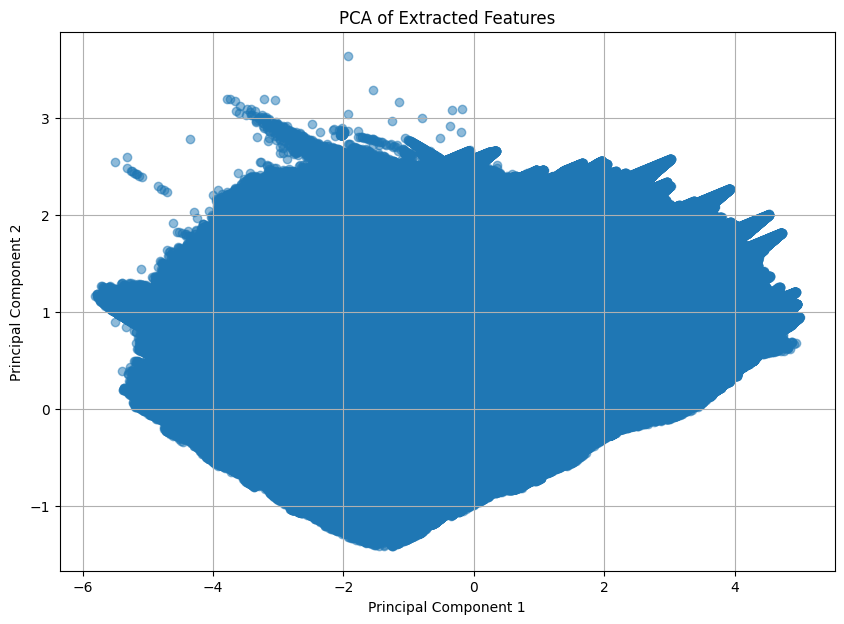

In [42]:
plt.figure(figsize=(10, 7))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], alpha=0.5)
plt.title('PCA of Extracted Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()


In [47]:
from sklearn.cluster import KMeans
inertias = []
k_range = range(1, 11)  # You can adjust the upper limit as needed

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(combined_features)
    inertias.append(kmeans.inertia_)


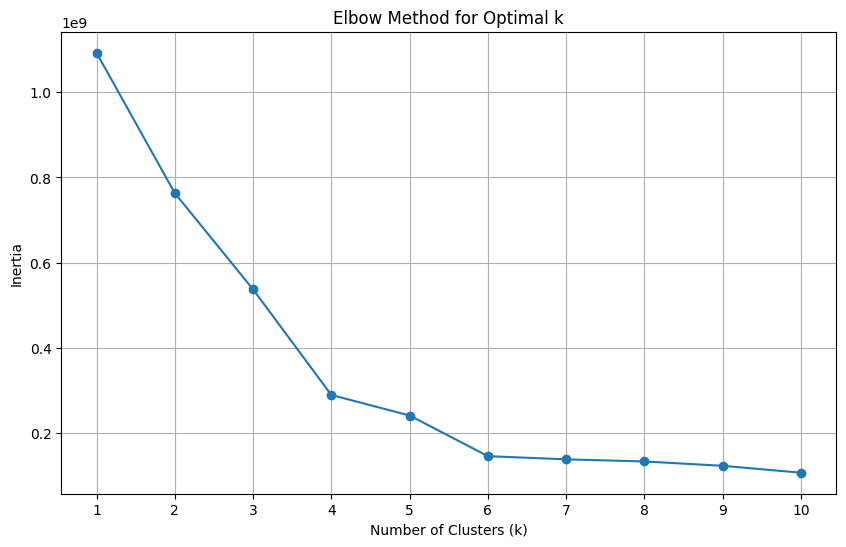

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid()
plt.show()


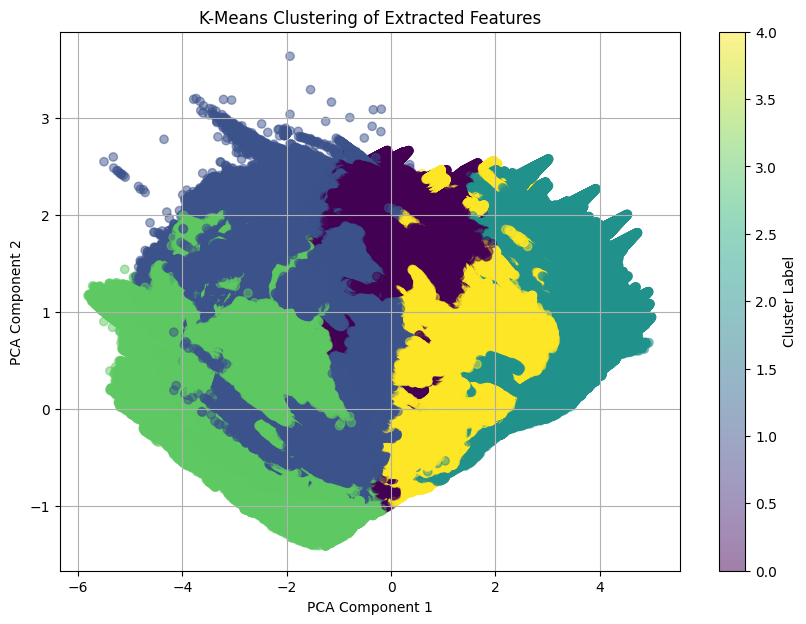

In [49]:
# Choose the number of clusters
k = 5  # You can change this based on your analysis
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(combined_features)

# Get the cluster labels
labels = kmeans.labels_

# Optional: Visualize the clusters (after reducing dimensions)
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(combined_features)

# Plot the clusters
plt.figure(figsize=(10, 7))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, alpha=0.5, cmap='viridis')
plt.title('K-Means Clustering of Extracted Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.grid()
plt.show()

In [51]:
len(labels)

223109366